# Solving a real problem using our model: The Discrete Flashing Ratchet (DFR)
The following is adapted from {cite}`fim_mjp` and shows a step by step example for solving problems using our [trained model from Hugging Face](https://huggingface.co/FIM4Science/fim-mjp). This notebook is a detailed example of solving a physics problem using our model using the following approach:

1. Understanding the problem
2. Loading and understanding the data
3. Using our model to infer the transition rates
4. Using the inferred transition rates to solve the original problem 




In statistical physics, the ratchet effect refers to the rectification of thermal fluctuations into directed motion to produce work, and goes all the way back to Feynman {cite}`feynman1965feynman`.

Here we consider a simple example thereof, in which a Brownian particle, immersed in a thermal bath at unit temperature, moves on a one-dimensional lattice.
The particle is subject to a linear, periodic and asymmetric potential of maximum height $2V$ that is switched on and off at a constant rate $r$.
The potential has three possible values when is switched on, which correspond to three of the states of the system. 
The particle jumps among them with rate $f_{ij}^{\tiny{\text{ on}}}$.

When the potential is switched off, the particle jumps freely with rate $f_{ij}^{\tiny{\text{ off}}}$.
We can therefore think of the system as a six-state system, as illustrated here: 
![](mjp_dlr.png)

Similar to {cite}`roldan10`, we now define the transition rates as
```{math}
    f_{ij}^{\tiny{\text{on}}} = \exp \left( -\frac{V}{2}(j-i)\right), \, \, \, \text{for} \, \, i, j \in (0, 1, 2); \quad f_{ij}^{\tiny{\text{ off}}} = b, \, \, \, \text{for} \, \, i, j \in (3, 4, 5).
```
Given these specifics, we consider the parameter set $(V, r, B) = (1, 1, 1)$  
together with the dataset simulated by {cite}`neural_mjp`,

So given our data, we want to recover the theoretical transition rates, as a q-matrix.[^footnote1]
[^footnote1]: That is with the diagonal entries normalized to the negative sum of the transition rates

In [9]:
import numpy as np
np.set_printoptions(linewidth=100)

rates_on=np.array([[np.exp(-0.5*(j-i))-1*(i==j) for j in range(3)] for i in range(3)])
rates_off=np.ones(shape=(3,3))
np.fill_diagonal(rates_off, 0)
id3=np.eye(3)
q_matrix=np.zeros(shape=(6,6))
q_matrix[:3,:3]=rates_on
q_matrix[3:,3:]=rates_off 
q_matrix[3:,:3]=id3
q_matrix[:3,3:]=id3
diagonal=-np.sum(q_matrix,axis=1)
np.fill_diagonal(q_matrix, diagonal)

In [10]:
q_matrix

array([[-1.9744101 ,  0.60653066,  0.36787944,  1.        ,  0.        ,  0.        ],
       [ 1.64872127, -3.25525193,  0.60653066,  0.        ,  1.        ,  0.        ],
       [ 2.71828183,  1.64872127, -5.3670031 ,  0.        ,  0.        ,  1.        ],
       [ 1.        ,  0.        ,  0.        , -3.        ,  1.        ,  1.        ],
       [ 0.        ,  1.        ,  0.        ,  1.        , -3.        ,  1.        ],
       [ 0.        ,  0.        ,  1.        ,  1.        ,  1.        , -3.        ]])

## Loading and exploring the data
We start by loading the simulated data from Hugging Face:

In [11]:
# Loading the Discrete Flashing Ratchet (DFR) dataset from Huggingface
from datasets import load_dataset
import torch
data = load_dataset("FIM4Science/mjp", download_mode="force_redownload", name="default")
data.set_format("torch")

Repo card metadata block was not found. Setting CardData to empty.


data/V1.json:   0%|          | 0.00/27.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1 [00:00<?, ? examples/s]

The model will later use the 'observation_grid', 'observation_values', 'seq_lengths' features to estimate the transition rates.

Here the observation grid is constant over all paths, consisting of 100 evenly spaced points on $[0,1]$. The sequence lengths of the dataset is therefore just 100 for all paths.

In [12]:
data["train"]["observation_grid"][0][0,0,:,0]

tensor([0.0000, 0.0101, 0.0202, 0.0303, 0.0404, 0.0505, 0.0606, 0.0707, 0.0808,
        0.0909, 0.1010, 0.1111, 0.1212, 0.1313, 0.1414, 0.1515, 0.1616, 0.1717,
        0.1818, 0.1919, 0.2020, 0.2121, 0.2222, 0.2323, 0.2424, 0.2525, 0.2626,
        0.2727, 0.2828, 0.2929, 0.3030, 0.3131, 0.3232, 0.3333, 0.3434, 0.3535,
        0.3636, 0.3737, 0.3838, 0.3939, 0.4040, 0.4141, 0.4242, 0.4343, 0.4444,
        0.4545, 0.4646, 0.4747, 0.4848, 0.4949, 0.5051, 0.5152, 0.5253, 0.5354,
        0.5455, 0.5556, 0.5657, 0.5758, 0.5859, 0.5960, 0.6061, 0.6162, 0.6263,
        0.6364, 0.6465, 0.6566, 0.6667, 0.6768, 0.6869, 0.6970, 0.7071, 0.7172,
        0.7273, 0.7374, 0.7475, 0.7576, 0.7677, 0.7778, 0.7879, 0.7980, 0.8081,
        0.8182, 0.8283, 0.8384, 0.8485, 0.8586, 0.8687, 0.8788, 0.8889, 0.8990,
        0.9091, 0.9192, 0.9293, 0.9394, 0.9495, 0.9596, 0.9697, 0.9798, 0.9899,
        1.0000])

In [13]:
print(data["train"]["observation_values"][0][0,0,:,0])
print(data["train"]["observation_values"][0][0,300,:,0])

tensor([2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5])


The observation values contain the state of the processes for all paths and all time points. 
```{warning} In practice these labels will rarely be directly observed values, since those will, in most cases, have to be computed as part of the preprocessing.
```
We can visualize the first 3 paths to get a feeling for the processes:

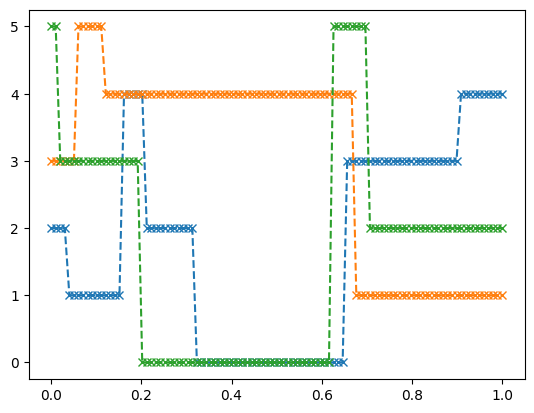

In [14]:
import  matplotlib.pyplot as plt
ts=data["train"]["observation_grid"][0][0,0,:,0]
three_paths=data["train"]["observation_values"][0][0,:3,:,0]
for i in range(3):
    plt.plot(ts,three_paths[i],"x--")
plt.show()

## Inferring transition rates

To infer the $q$-matrix we first load our trained model:

In [ ]:

from fim.trainers.utils import get_accel_type
device = get_accel_type() 


from fim.models.mjp import FIMMJP
fimmjp = FIMMJP.from_pretrained("FIM4Science/fim-mjp-updated", trust_remote_code=True)


fimmjp = fimmjp.to(device)
fimmjp.eval()

FIMMJP(
  (gaussian_nll): GaussianNLLLoss()
  (init_cross_entropy): CrossEntropyLoss()
  (pos_encodings): SineTimeEncoding(
    (linear_embedding): Linear(in_features=1, out_features=1, bias=True)
    (periodic_embedding): Sequential(
      (0): Linear(in_features=1, out_features=249, bias=True)
      (1): SinActivation()
    )
  )
  (ts_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=1024, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Drop

As noted in {cite}`fim_mjp`[^footnote2] it suffices to look at a small context window of 300 paths with 50 observation values each. We therefore infer the 
transition rates batchwise to demonstrate how little data might be needed. 

[^footnote2]: Section 4.1 and E.4

In [16]:
# copy data to device
batch = {k: v.to(device)[0] for k, v in data["train"][:1].items() if not k in ["intensity_matrices","adjacency_matrices","initial_distributions"]}  # data without any information, we seek to find

n_paths = 300
total_n_paths = batch["observation_grid"][0].shape[0]
statistics = 50

outputs=[]

with torch.no_grad():
    for _ in range(statistics):
        paths_idx = torch.randperm(total_n_paths)[:n_paths]
        mini_batch = batch.copy()
        mini_batch["observation_grid"] = batch["observation_grid"][:, paths_idx]
        mini_batch["observation_values"] = batch["observation_values"][:, paths_idx]
        mini_batch["seq_lengths"] = batch["seq_lengths"][:, paths_idx]
        #print(mini_batch["observation_values"][0,:,:,0])
        #print(total_n_paths)
        #print(paths_idx.shape)
        outputs.append(fimmjp(mini_batch, n_states=6)["intensity_matrices"])# We are currently not interested in variances or initial conditions

In [17]:
mean_rates=torch.mean(torch.stack(outputs,dim=0),dim=0)[0].to("cpu").numpy()

This results in the following inferred transition rates:

[[-2.1689546   0.5783726   0.30212468  1.1319824   0.0871964   0.06927856]
 [ 1.8087431  -3.6506543   0.60985875  0.11247499  1.0123525   0.10722499]
 [ 2.3694391   1.9987228  -5.7144914   0.24644603  0.21699314  0.8828906 ]
 [ 0.9084651   0.10738878  0.08176861 -3.2432315   1.0093113   1.1362975 ]
 [ 0.08572728  0.9417358   0.12976512  1.0478365  -3.2570217   1.0519569 ]
 [ 0.14386144  0.16973484  0.9709588   1.0300897   0.9557102  -3.2703552 ]]


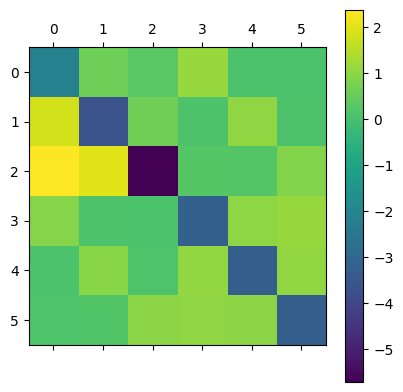

In [18]:
mean_rates=torch.mean(torch.stack(outputs,dim=0),dim=0)[0].to("cpu").numpy()
print(mean_rates)
plt.matshow(mean_rates)
plt.colorbar()
plt.show()

and the following variances:

[[1.45309633e-02 2.65904865e-03 3.47121269e-03 8.10336322e-03 2.76589162e-05 1.88254508e-05]
 [2.29007062e-02 6.99593648e-02 2.61672270e-02 4.04276070e-05 1.90784689e-02 1.04088889e-04]
 [3.58723737e-02 2.63915546e-02 1.32420495e-01 8.61452834e-04 5.04448370e-04 3.66542935e-02]
 [9.56915971e-03 3.01110304e-05 3.83986662e-05 3.71510051e-02 7.67555693e-03 1.40112666e-02]
 [3.10932555e-05 1.77779924e-02 7.63407370e-05 8.26456025e-03 4.47372273e-02 1.58222467e-02]
 [2.76222097e-04 2.66238756e-04 1.22979805e-02 2.99598314e-02 2.68870220e-02 7.02932924e-02]]


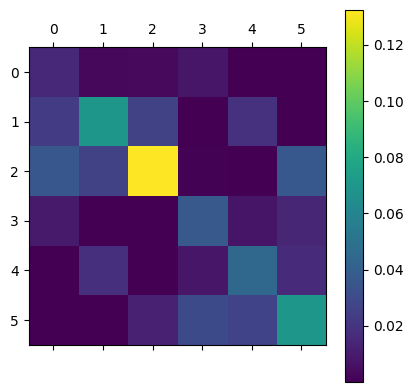

In [19]:
variances=torch.var(torch.stack(outputs,dim=0),dim=0)[0].to("cpu").numpy()
print(variances)
plt.matshow(variances)
plt.colorbar()
plt.show()

Using the previously computed theoretical transition rates we can look at the pointwise error:

[[-0.19454451 -0.02815806 -0.06575476  0.13198245  0.0871964   0.06927856]
 [ 0.16002185 -0.39540239  0.00332809  0.11247499  0.01235247  0.10722499]
 [-0.3488427   0.35000152 -0.34748827  0.24644603  0.21699314 -0.11710942]
 [-0.09153491  0.10738878  0.08176861 -0.24323153  0.00931132  0.13629746]
 [ 0.08572728 -0.0582642   0.12976512  0.04783654 -0.25702167  0.05195689]
 [ 0.14386144  0.16973484 -0.02904117  0.03008974 -0.04428983 -0.27035522]]


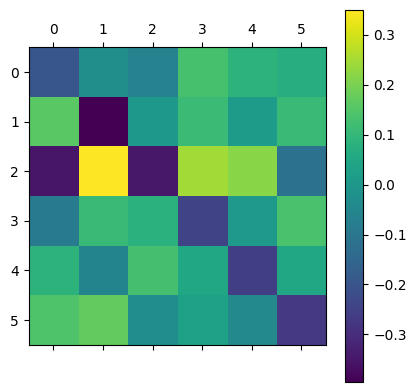

In [20]:
error=mean_rates-q_matrix
print(error)
plt.matshow(error)
plt.colorbar()
plt.show()

## Inferring the parameters
We will now use the transition rates to recover the parameters used to generate the dataset. Recall the formula we previously used to calculate the theoretical transition rates:
```{math}
    f_{ij}^{\tiny{\text{on}}} = \exp \left( -\frac{V}{2}(j-i)\right), \, \, \, \text{for} \, \, i, j \in (0, 1, 2); \quad f_{ij}^{\tiny{\text{ off}}} = b, \, \, \, \text{for} \, \, i, j \in (3, 4, 5).
```
The $q$-matrix (transition rate matrix) is therefore given by 
```{math}
q=\begin{pmatrix}
f_{ij}^{\tiny{\text{on}}} & r\cdot I_3\\
r\cdot I_3 & f_{ij}^{\tiny{\text{ off}}}
\end{pmatrix}
```
since the transition rates between $(i,j,\text{on})$ and $(i,j,\text{off})$ (and vice versa) are given by the parameter $r$.

This system is evidently overdetermined. For simplicity we assume normally distributed independent errors, which results in the following MLEs for each of the parameters:

We can easily recover $b$ using the diagonal:
```{math}
    \hat{b}=\frac{1}{6}\sum_{i=3}^5\sum_{j=3}^51_{i\neq j}f_{ij}^{\tiny{\text{off}}}
```

In [21]:
lower_matrix=mean_rates[3:,3:]
np.fill_diagonal(lower_matrix, 0)

B_hat=lower_matrix.sum()/6
B_hat

np.float32(1.0385337)

Similarly $r$ describes the transition rates from a state $(i,j,\text{on})$ to $(i,j,\text{off})$ and vice versa:
```{math}
    \hat{r}=\frac{1}{6}\sum_{i=0}^2 q_{i,i+3}+q_{i+3,i}
```

In [22]:
r_hat=sum([mean_rates[i,i+3]+mean_rates[i+3,i] for i in range(3)])/6
r_hat

np.float32(0.9747308)

And  $V$ can be recovered using $(q_{i,j})_{i,j=1}^3$:
```{math}
    \hat{V}=\frac{1}{6}\left(-2\cdot(\ln q_{0,1}+\ln q_{1,2})+2\cdot(\ln q_{1,0}+\ln q_{2,1})- \ln q_{0,2}+ \ln q_{2,0}\right)
```

In [23]:
V_hat=(-2*(np.log(mean_rates[0,1])+np.log(mean_rates[1,2]))+2*(np.log(mean_rates[1,0])+np.log(mean_rates[2,1]))-np.log(mean_rates[0,2])+np.log(mean_rates[2,0]))/6
V_hat

np.float32(1.1189966)

Which results in the following inferred parameters:

In [24]:
(V_hat,r_hat,B_hat)

(np.float32(1.1189966), np.float32(0.9747308), np.float32(1.0385337))

## Bibliography
```{bibliography}
:style: alpha
:filter: docname in docnames
```